This notebook creates a network of FS neurons and runs the simulation with and without gap junctions.

First we define a cubic millimeter volume for the FS neurons.

In [1]:
import os
os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example. You can run this example without it, but then do not execute this cell."

network_path = os.path.join("FS_network_1")

In [ ]:
from snudda.place import create_cube_mesh

mesh_file = os.path.join(network_path, "mesh", "volume.obj")
create_cube_mesh(mesh_file, [0,0,0], 1e-3, "FS network volume")

Create config file defining the network. Here 1050 FS neurons are added.

In [ ]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="StriatalVolume", struct_mesh=mesh_file, d_min=15e-6, mesh_bin_width=50e-6)

# Should be 1050 neurons, temp reducing it to 50 neurons for runtime of simulation while developing
si.add_neurons(name="FS", num_neurons=50, volume_id="StriatalVolume",
               neuron_dir=os.path.join("$DATA","neurons","striatum","fs"))

cluster_FS_synapses = True
FS_gGABA = [1.1e-9, 1.5e-9]
FS_gGapJunction = [0.5e-9, 0.1e-9]

si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GABA",
                     dist_pruning=None,
                     f1=0.15, soft_max=5, mu2=2, a3=1,
                     conductance=FS_gGABA,
                     cluster_synapses=cluster_FS_synapses,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.33e-3, 1e3),
                                               "tau2": (5.7e-3, 1e3)})
    
si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GapJunction",
                     dist_pruning=None,
                     f1=0.7, soft_max=8, mu2=2, a3=1.0,
                     conductance=FS_gGapJunction,
                     cluster_synapses=False,
                     channel_param_dictionary=None)

si.write_json()

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path)
sd.detect()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

In [2]:
import os
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file="example-FS-input.json",
                 verbose=False)
si.generate()

Loading 50 neurons with 50 synapses and 16 gap junctions
Writing spikes to FS_network_1/input-spikes.hdf5


In [ ]:
!nrnivmodl $SNUDDA_DATA/neurons/mechanisms

In [3]:
!mpiexec -n 2 snudda simulate FS_network_1 --time 1

numprocs=2
Using input file FS_network_1/input-spikes.hdf5
Using input file FS_network_1/input-spikes.hdf5
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
args: Namespace(action='simulate', disable_gj=False, exportCoreNeuron=False, input_file=None, mech_dir=None, network_file=None, neuromodulation=None, output_file=None, path='FS_network_1', profile=False, randomseed=None, record_all=None, record_volt=True, time=1.0, verbose=False)
args: Namespace(action='simulate', disable_gj=False, exportCoreNeuron=False, input_file=None, mech_dir=None, network_file=None, neuromodulation=None, output_file=None, path='FS_network_1', profile=False, randomseed=None, rec

Loading FS_network_1/simulation/network-output.hdf5
> /home/hjorth/HBP/Snudda/snudda/plotting/plot_cross_correlogram.py(24)calculate_all_pair_cross_correlogram()
     22         pdb.set_trace()
     23 
---> 24         for na in spike_data.keys():
     25 
     26             if spike_data[na].size == 0:

ipdb> spike_data
{0: array([], shape=(1, 0), dtype=float64), 1: array([[0.217825, 0.396175, 0.605225, 0.810325, 0.92485 , 0.961075,
        0.99935 ]]), 10: array([[0.991325]]), 11: array([], shape=(1, 0), dtype=float64), 12: array([], shape=(1, 0), dtype=float64), 13: array([], shape=(1, 0), dtype=float64), 14: array([[0.2881  , 0.52135 , 0.6652  , 0.69555 , 0.707825, 0.735325,
        0.749225, 0.763075, 0.780625, 0.79625 , 0.8077  , 0.848525,
        0.85635 , 0.87725 , 0.89425 , 0.90815 , 0.92565 , 0.943075,
        0.9935  ]]), 15: array([[0.4345  , 0.45975 , 0.480475, 0.5754  , 0.6642  , 0.7264  ,
        0.77065 ]]), 16: array([[0.158425, 0.198925, 0.21485 , 0.29635 , 0.53485 ,

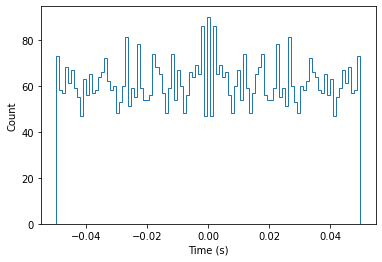

<Figure size 432x288 with 0 Axes>

In [4]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "network-output.hdf5"))
pcc.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr.png"))